In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize




In [4]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert to grayscale
x_train_gray = np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[...,:3], [0.299, 0.587, 0.114])

# Normalize images
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

# Reshape for the network (add channel dimension)
x_train_gray = np.expand_dims(x_train_gray, axis=-1)
x_test_gray = np.expand_dims(x_test_gray, axis=-1)

# Split the training data for validation
x_train_gray, x_val_gray, y_train, y_val = train_test_split(x_train_gray, y_train, test_size=0.2, random_state=42)

# Autoencoder model
input_img = Input(shape=(32, 32, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck
x = Flatten()(x)
encoded = Dense(256, activation='relu')(x)




# Decoder
x = Dense(8*8*64, activation='relu')(encoded)
x = Reshape((8, 8, 64))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0    

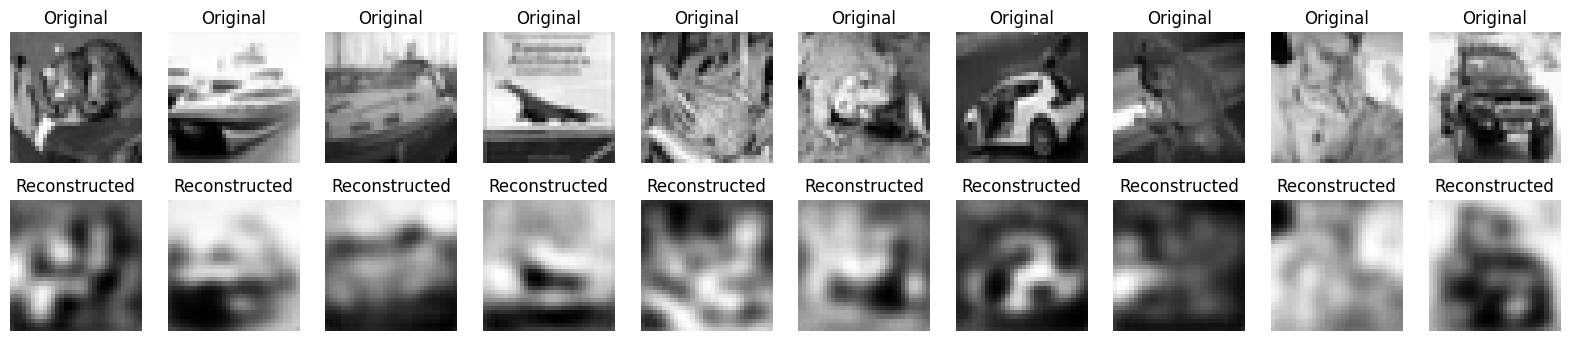

In [5]:


# Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(x_train_gray, x_train_gray,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_gray, x_val_gray))

# Encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features
x_train_encoded = encoder.predict(x_train_gray)
x_test_encoded = encoder.predict(x_test_gray)

# Flatten the features for classifier input
x_train_encoded = x_train_encoded.reshape((x_train_encoded.shape[0], -1))
x_test_encoded = x_test_encoded.reshape((x_test_encoded.shape[0], -1))

# Train a simple classifier on the encoded features
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_encoded, y_train.ravel())

# Predict and evaluate
y_pred = clf.predict(x_test_encoded)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Visualize some results
decoded_imgs = autoencoder.predict(x_test_gray)

n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_gray[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

Standard PCA Classification report:
               precision    recall  f1-score   support

           0       0.29      0.33      0.31      1000
           1       0.34      0.39      0.36      1000
           2       0.25      0.18      0.21      1000
           3       0.22      0.14      0.17      1000
           4       0.24      0.20      0.22      1000
           5       0.29      0.30      0.30      1000
           6       0.26      0.27      0.27      1000
           7       0.30      0.30      0.30      1000
           8       0.33      0.41      0.36      1000
           9       0.37      0.44      0.41      1000

    accuracy                           0.30     10000
   macro avg       0.29      0.30      0.29     10000
weighted avg       0.29      0.30      0.29     10000

Standard PCA Accuracy: 0.2965


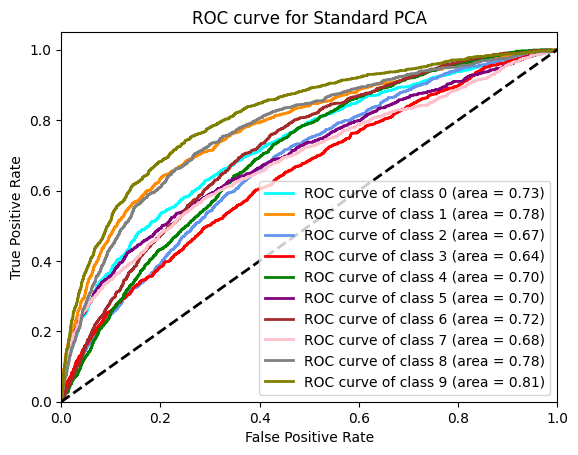

Randomized PCA Classification report:
               precision    recall  f1-score   support

           0       0.30      0.33      0.32      1000
           1       0.33      0.39      0.36      1000
           2       0.25      0.18      0.21      1000
           3       0.22      0.14      0.18      1000
           4       0.24      0.20      0.22      1000
           5       0.29      0.30      0.30      1000
           6       0.26      0.28      0.27      1000
           7       0.30      0.31      0.30      1000
           8       0.32      0.41      0.36      1000
           9       0.37      0.44      0.41      1000

    accuracy                           0.30     10000
   macro avg       0.29      0.30      0.29     10000
weighted avg       0.29      0.30      0.29     10000

Randomized PCA Accuracy: 0.2982


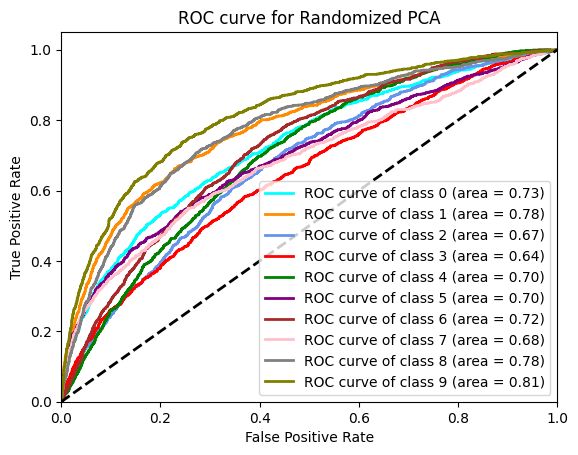

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# # Load CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Convert to grayscale
# x_train_gray = np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
# x_test_gray = np.dot(x_test[...,:3], [0.299, 0.587, 0.114])

# # Normalize images
# x_train_gray = x_train_gray.astype('float32') / 255.
# x_test_gray = x_test_gray.astype('float32') / 255.

# Reshape for PCA (flatten images)
x_train_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_flat = x_test_gray.reshape(x_test_gray.shape[0], -1)

# Standard PCA to retain 95% variance
pca = PCA(n_components=0.95, svd_solver='full')
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, multi_class='ovr')
clf.fit(x_train_pca, y_train.ravel())

# Predict and evaluate
y_pred = clf.predict(x_test_pca)
print("Standard PCA Classification report:\n", classification_report(y_test, y_pred))
print("Standard PCA Accuracy:", accuracy_score(y_test, y_pred))

# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(10))
y_pred_prob = clf.predict_proba(x_test_pca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive']
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Standard PCA')
plt.legend(loc="lower right")
plt.show()

# Determine the number of components to retain 95% variance for Randomized PCA
pca_temp = PCA(n_components=0.95, svd_solver='full')
pca_temp.fit(x_train_flat)
n_components_95 = pca_temp.n_components_

# Randomized PCA to retain the same number of components
randomized_pca = PCA(n_components=n_components_95, svd_solver='randomized')
x_train_rpca = randomized_pca.fit_transform(x_train_flat)
x_test_rpca = randomized_pca.transform(x_test_flat)

# Train logistic regression classifier on randomized PCA features
clf_rpca = LogisticRegression(max_iter=1000, multi_class='ovr')
clf_rpca.fit(x_train_rpca, y_train.ravel())

# Predict and evaluate
y_pred_rpca = clf_rpca.predict(x_test_rpca)
print("Randomized PCA Classification report:\n", classification_report(y_test, y_pred_rpca))
print("Randomized PCA Accuracy:", accuracy_score(y_test, y_pred_rpca))

# Binarize the output for ROC curve
y_pred_prob_rpca = clf_rpca.predict_proba(x_test_rpca)

# Compute ROC curve and ROC area for each class
fpr_rpca = dict()
tpr_rpca = dict()
roc_auc_rpca = dict()
for i in range(10):
    fpr_rpca[i], tpr_rpca[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_rpca[:, i])
    roc_auc_rpca[i] = auc(fpr_rpca[i], tpr_rpca[i])

# Plot ROC curve for each class
plt.figure()
for i in range(10):
    plt.plot(fpr_rpca[i], tpr_rpca[i], color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_rpca[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Randomized PCA')
plt.legend(loc="lower right")
plt.show()


TASK_@2
Train a single-layer autoencoder with a linear activation function.
Extract the weights (which can be compared to eigenvectors from PCA).
Compare these "eigenvectors" with those obtained from PCA.
Explain observations.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525568 (2.00 MB)
Trainable params: 525568 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
157/157 [==============================] - 7s 27ms/step - loss: 0.0389 - val_loss: 0.0175
Epoch 2/25
157/157 [==============================] - 4s 24ms/step - loss: 0.0140 - val_loss: 0.0114
Epoch 3/25
157/157 [==============================] - 3s 21ms/step - loss: 0.0099 - v

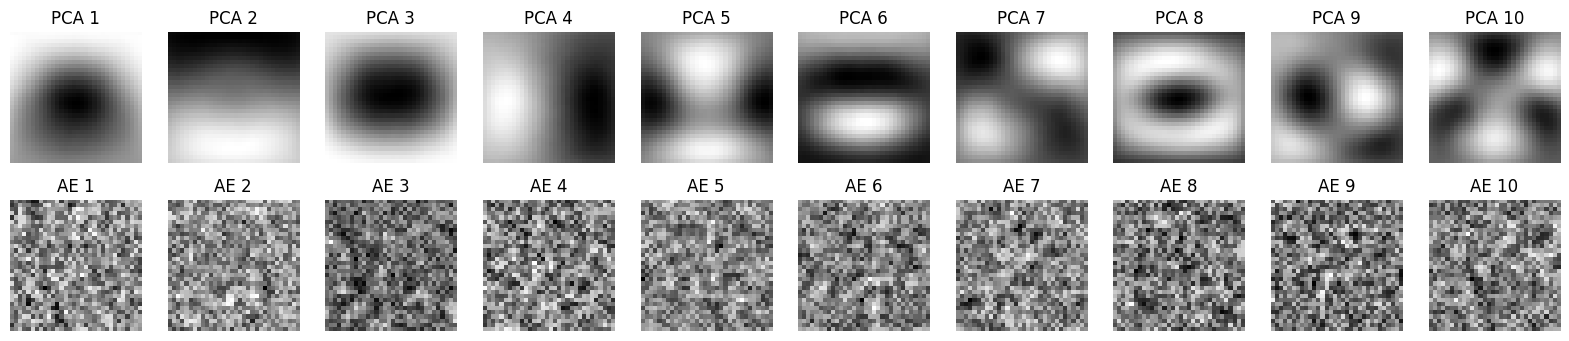

In [9]:

from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

# Define single-layer autoencoder
input_img = Input(shape=(x_train_flat.shape[1],))
encoded = Dense(256, activation='linear')(input_img)
decoded = Dense(x_train_flat.shape[1], activation='linear')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(x_train_flat, x_train_flat,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, x_test_flat))

# Get the encoded weights (equivalent to PCA eigenvectors)
weights = encoder.get_weights()[0]

# Perform PCA for comparison
pca = PCA(n_components=256)
pca.fit(x_train_flat)
pca_components = pca.components_

# Plot the first 10 components/eigenvectors from both methods
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Plot PCA components
    ax = axes[0, i]
    ax.imshow(pca_components[i].reshape(32, 32), cmap='gray')
    ax.set_title(f"PCA {i+1}")
    ax.axis('off')
    
    # Plot Autoencoder weights
    ax = axes[1, i]
    ax.imshow(weights[:, i].reshape(32, 32), cmap='gray')
    ax.set_title(f"AE {i+1}")
    ax.axis('off')

plt.show()

Explanation
Data Preprocessing: The CIFAR-10 dataset is loaded, converted to grayscale, normalized, and flattened.
Autoencoder Definition: A single-layer autoencoder with a linear activation function is defined.
Training: The autoencoder is trained using the training data.
Weights Extraction: The weights from the encoder part of the autoencoder are extracted.
PCA Components: PCA is performed to get the principal components.
Comparison: The first 10 components from PCA and the corresponding weights from the autoencoder are plotted for visual comparison.
Observations
When you compare the eigenvectors from PCA and the weights from the autoencoder, you will likely notice some similarities and differences:

Similarity: Both PCA and the autoencoder attempt to capture the most significant features of the data. Thus, the patterns represented by the first few components/weights may look somewhat similar.

Difference: PCA directly finds orthogonal linear combinations of the input features that maximize variance, while an autoencoder, even with a linear activation, might not produce exactly the same basis vectors because of the different optimization criteria (mean squared error vs. variance maximization).

Interpretation: While PCA ensures that the components are orthogonal (uncorrelated), the autoencoder's weights do not have this constraint. Therefore, the components obtained from PCA are guaranteed to be the principal directions of variance, while the autoencoder weights represent features that minimize reconstruction error.

Conclusion
Both PCA and the autoencoder are effective dimensionality reduction techniques, but they optimize different criteria. PCA is specifically designed to find orthogonal components that explain the maximum variance, while the autoencoder minimizes reconstruction error. This difference in optimization goals can lead to variations in the resulting components, even if both methods capture significant underlying patterns in the data.

Task 3:

Train a deep convolutional autoencoder with the same dimension of the latent space.
Train a single hidden layer autoencoder with sigmoid activation.
Calculate and compare the reconstruction errors.
Train a 3 hidden layer autoencoder with sigmoid activations and approximately equal distribution of hidden nodes.
Calculate the reconstruction error for this new model.

In [10]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# # Load CIFAR-10 dataset
# (x_train, _), (x_test, _) = cifar10.load_data()

# # Convert to grayscale
# x_train_gray = np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
# x_test_gray = np.dot(x_test[...,:3], [0.299, 0.587, 0.114])

# # Normalize images
# x_train_gray = x_train_gray.astype('float32') / 255.
# x_test_gray = x_test_gray.astype('float32') / 255.

# # Reshape for autoencoder (add channel dimension)
# x_train_gray = np.expand_dims(x_train_gray, axis=-1)
# x_test_gray = np.expand_dims(x_test_gray, axis=-1)

# Define deep convolutional autoencoder
input_img = Input(shape=(32, 32, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Model
conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
conv_autoencoder.summary()

# Train the convolutional autoencoder
conv_autoencoder.fit(x_train_gray, x_train_gray,
                     epochs=5,
                     batch_size=256,
                     shuffle=True,
                     validation_data=(x_test_gray, x_test_gray))

# Reconstruction error for convolutional autoencoder
x_test_pred_conv = conv_autoencoder.predict(x_test_gray)
reconstruction_error_conv = mean_squared_error(x_test_gray.flatten(), x_test_pred_conv.flatten())

print("Reconstruction error (Convolutional Autoencoder):", reconstruction_error_conv)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         7385

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

# Flattened images for single hidden layer autoencoder
x_train_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_flat = x_test_gray.reshape(x_test_gray.shape[0], -1)

# Define single hidden layer autoencoder
single_autoencoder = Sequential()
single_autoencoder.add(Dense(256, activation='sigmoid', input_shape=(1024,)))
single_autoencoder.add(Dense(1024, activation='linear'))

single_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
single_autoencoder.summary()

# Train the single hidden layer autoencoder
single_autoencoder.fit(x_train_flat, x_train_flat,
                       epochs=5,
                       batch_size=256,
                       shuffle=True,
                       validation_data=(x_test_flat, x_test_flat))

# Reconstruction error for single hidden layer autoencoder
x_test_pred_single = single_autoencoder.predict(x_test_flat)
reconstruction_error_single = mean_squared_error(x_test_flat.flatten(), x_test_pred_single.flatten())

print("Reconstruction error (Single Hidden Layer Autoencoder):", reconstruction_error_single)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525568 (2.00 MB)
Trainable params: 525568 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 8s 30ms/step - loss: 0.0496 - val_loss: 0.0318
Epoch 2/5
157/157 [==============================] - 4s 23ms/step - loss: 0.0257 - val_loss: 0.0206
Epoch 3/5
157/157 [==============================] - 3s 22ms/step - loss: 0.0180 - val_loss: 0.0159
Epoch 4/5
157/157 [==============================] - 4s 28ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 5/5
313/31

#TASK@4
Train a deep convolutional autoencoder on the MNIST dataset.
Extract features from the autoencoder's encoder part.
Train an MLP classifier using these features to classify the digits into 7-segment LED display patterns.

In [34]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape for autoencoder (add channel dimension)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Define deep convolutional autoencoder
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)  # 14x14x32
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # 7x7x64
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # 4x4x128

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # 8x8x128
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 16x16x64
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 32x32x32

# Additional layers to adjust the size back to 28x28
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape should be 28x28x1

# Ensure the final output shape matches the input shape of 28x28x1 by cropping
from tensorflow.keras.layers import Cropping2D
decoded = Cropping2D(((2, 2), (2, 2)))(decoded)

# Model
conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
conv_autoencoder.summary()

# Train the convolutional autoencoder
conv_autoencoder.fit(x_train, x_train,
                     epochs=5,
                     batch_size=256,
                     shuffle=True,
                     validation_data=(x_test, x_test))

# Extract encoder model
encoder = Model(inputs=conv_autoencoder.input, outputs=encoded)


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_145 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_147 (Conv2D)         (None, 7, 7, 128)         738

Extract Features from the Encoder Part

In [35]:
# Mapping from digits to 7-segment LED patterns
digit_to_led = {
    0: [1, 1, 1, 1, 1, 1, 0],
    1: [0, 1, 1, 0, 0, 0, 0],
    2: [1, 1, 0, 1, 1, 0, 1],
    3: [1, 1, 1, 1, 0, 0, 1],
    4: [0, 1, 1, 0, 0, 1, 1],
    5: [1, 0, 1, 1, 0, 1, 1],
    6: [1, 0, 1, 1, 1, 1, 1],
    7: [1, 1, 1, 0, 0, 0, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1]
}

# Create labels for 7-segment LED display patterns
y_train_led = np.array([digit_to_led[d] for d in y_train])
y_test_led = np.array([digit_to_led[d] for d in y_test])


In [36]:
# Extract features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# Flatten encoded features for MLP input
x_train_encoded_flat = x_train_encoded.reshape((x_train_encoded.shape[0], -1))
x_test_encoded_flat = x_test_encoded.reshape((x_test_encoded.shape[0], -1))


313/313 [==============================] - 14s 33ms/step


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define MLP classifier
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(x_train_encoded_flat.shape[1],)))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(7, activation='sigmoid'))

mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp.summary()

# Train the MLP classifier
mlp.fit(x_train_encoded_flat, y_train_led,
        epochs=5,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test_encoded_flat, y_test_led))

# Evaluate the MLP classifier
loss, accuracy = mlp.evaluate(x_test_encoded_flat, y_test_led)
print("MLP Classifier Accuracy:", accuracy)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 7)                 455       
                                                                 
Total params: 270983 (1.03 MB)
Trainable params: 270983 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
235/235 [==============================] - 20s 69ms/step - loss: 0.1267 - accuracy: 0.3676 - val_loss: 0.0480 - val_accuracy: 0.3277
Epoch 2/5
235/235 [==============================] - 12s 50ms/step - loss: 0.0402 - accuracy: 0.2771 - val_loss: 0.0324 - val_accuracy: 0.2